## PyOD - Histogram-based Outlier Detection

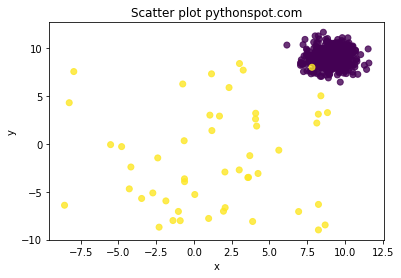

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.1 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 2      # number of features
X_train, y_train, X_test, y_test = generate_data(
 n_train=n_train, n_test=n_test, n_features= n_features, contamination=contamination)

# Make the 2d numpy array a pandas dataframe for each manipulation 
X_train_pd = pd.DataFrame(X_train)
    
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [7]:
# train kNN detector
from pyod.models.hbos import HBOS
n_bins = 50
hbos = HBOS(n_bins=n_bins)
hbos.fit(X_train)
HBOS(alpha=0.1, contamination=0.1, n_bins=n_bins, tol=0.5)
y_train_scores = hbos.decision_function(X_train)

In [8]:
# Now we have the trained K-NN model, let's apply to the test data to get the predictions
y_test_pred = hbos.predict(X_test) # outlier labels (0 or 1)
# Because it is '0' and '1', we can run a count statistic. There are 44 '1's and 456 '0's. The number of anomalies is roughly ten percent, as we have generated before:
unique, counts = np.unique(y_test_pred, return_counts=True)
dict(zip(unique, counts))
#{0: 456, 1: 44}
# And you can generate the anomaly score using clf.decision_function:
y_test_scores = clf.decision_function(X_test)

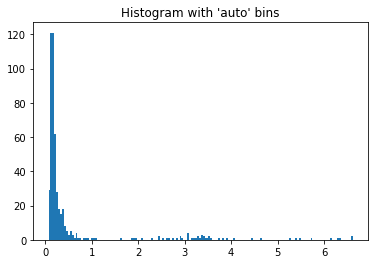

In [9]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [11]:
# Let's see how many '0's and '1's. We get 452 '0's and 48 '1's.
df_test = pd.DataFrame(X_test)
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<1, 0, 1)
df_test['cluster'].value_counts()
# Now let's show the summary statistics:
df_test.groupby('cluster').mean()

,0,1,score
cluster,,,
0,8.986251,9.050861,0.217078
1,-0.267520,0.200783,3.456578


In [14]:
#!pip install combo

In [16]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Test a range of bins
n_clf = 10
k_list = [5,10,1,20,25,30,35,40,45,50]
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape
# Modeling
for i in range(n_clf):
    k = k_list[i]
    hbos = HBOS(n_bins=k)
    hbos.fit(X_train_norm)

    # Store the results in each column:
    train_scores[:, i] = hbos.decision_scores_
    test_scores[:, i] = hbos.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

#### Method 1: Average

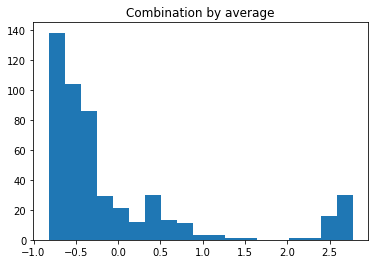

In [17]:
# Combination by average
# The test_scores_norm is 500 x 20. The "average" function will take the average of the 20 columns. The result "y_by_average" is a single column: 
y_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [20]:
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<0, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    361
1    139
Name: y_by_average_cluster, dtype: int64

In [23]:
df_test.groupby("y_by_average_cluster").mean()

,0,1,y_by_average_score
y_by_average_cluster,,,
0,8.963948,9.027748,-0.543046
1,5.449184,5.672728,1.196954


#### Method 2: The Maximum of Maximum (MOM)

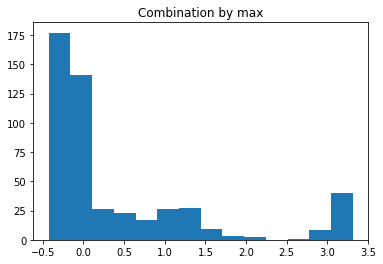

In [24]:
# Combination by mom
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [25]:
df_test = pd.DataFrame(X_test)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<0, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

0    297
1    203
Name: y_by_maximization_cluster, dtype: int64

#### Method 3: The Average of Maximum (AOM)

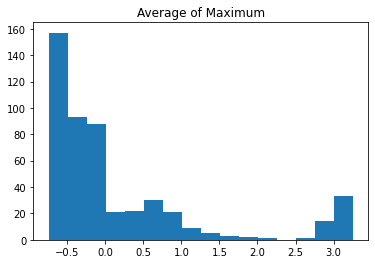

In [26]:
# Combination by aom
y_by_aom = aom(test_scores_norm, n_buckets=5)
             
import matplotlib.pyplot as plt
plt.hist(y_by_aom, bins='auto')  # arguments are passed to np.histogram
plt.title("Average of Maximum")
plt.show()

In [27]:
df_test = pd.DataFrame(X_test)
df_test['y_by_aom_score'] = y_by_aom
df_test['y_by_aom_cluster'] = np.where(df_test['y_by_aom_score']<0, 0, 1)
df_test['y_by_aom_cluster'].value_counts()

0    338
1    162
Name: y_by_aom_cluster, dtype: int64

In [28]:
df_test.groupby("y_by_aom_cluster").mean()

,0,1,y_by_aom_score
y_by_aom_cluster,,,
0,8.948814,9.001313,-0.442063
1,5.979771,6.204213,1.379286


#### Method 4: The maximum of average (MOA)

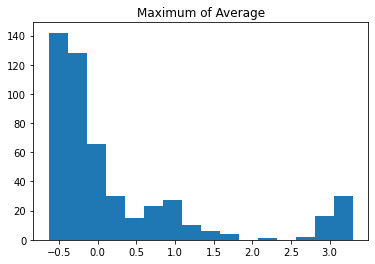

In [29]:
# Combination by moa
y_by_moa = moa(test_scores_norm, n_buckets=5)

import matplotlib.pyplot as plt
plt.hist(y_by_moa, bins='auto')  # arguments are passed to np.histogram
plt.title("Maximum of Average")
plt.show()

In [30]:
df_test = pd.DataFrame(X_test)
df_test['y_by_moa_score'] = y_by_moa
df_test['y_by_moa_cluster'] = np.where(df_test['y_by_moa_score']<0, 0, 1)
df_test['y_by_moa_cluster'].value_counts()

0    328
1    172
Name: y_by_moa_cluster, dtype: int64

In [31]:
df_test.groupby("y_by_moa_cluster").mean()

,0,1,y_by_moa_score
y_by_moa_cluster,,,
0,8.950935,9.023442,-0.362360
1,6.148344,6.324636,1.377015
